# Introduction

In this example we implement simple STA imaging for ultrasound environment. As an example we use raw echo data from sl1543 probe applied to a string phantom:

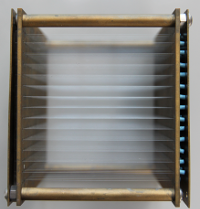

In this example we use:
1. beamforming op: we use STA (delay-and sum + 1-D interpolation op), which converts input echo response data to a b-mode frame.
2. signal envelope detection op: we convert b-mode frame to analytical signal (https://en.wikipedia.org/wiki/Analytic_signal).



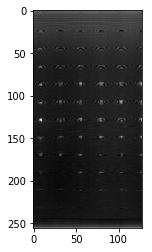

In [2]:
import tensorflow as tf
import waveflow as wf
import numpy as np
import pylab

rf = np.load('sta_string_phantom.npy')

sl1543 = wf.ultrasound.Probe(
  name = "sl1543",
  num_elements = 192,
  subaperture_size= 64,
  pitch = .21e-3,
  sampling_frequency=50e6,
  input_source=wf.io.NumpyArraySource(rf)
)

string_phantom = wf.physics.PhysicalEnv(
  speed_of_sound=1490.
)

with wf.ultrasound.UltrasoundEnv(probe=sl1543, physical_env=string_phantom) as us_env:
  input = us_env.step()
  # Event, Sample, Channel -> Event, Channel, Sample
  transposed = tf.transpose(input, perm=[0, 2, 1])
  reduced = wf.beamforming.sta(transposed, output_shape=(256, 128), start_depth=.005, us_env=us_env)
  transformed = wf.transforms.analytic_signal(tf.cast(reduced, dtype=tf.complex64), axis=0)
  frame = tf.abs(transformed)
  
  with tf.Session() as sess:
    img = frame.eval(session = sess)
    pylab.imshow(img, cmap='gray')